#GLOBAL SOLUTION – SOLUÇÕES EM ENERGIAS RENOVÁVEIS E SUSTENTÁVEIS

A base de dados utilizada reúne medições de consumo de energia de um estabelecimento comercial ao longo de um ano, registradas hora a hora. Além do consumo, inclui temperatura e variáveis derivadas, como hora do dia, dia da semana, mês, indicação de fim de semana e médias móveis. O objetivo é analisar padrões de consumo, identificar períodos de maior demanda, avaliar a influência da temperatura e propor ajustes para reduzir desperdícios, custos e impactos ambientais.

A amostra contém 8.784 registros (24 horas × 366 dias) e 17 variáveis.

Variáveis:

nivel_3, nivel_5, nivel_7: indicadores de medição interna do sistema elétrico.

consumo: consumo bruto registrado (em Wh).

consumo_kwh: consumo convertido para kWh.

temperatura: temperatura ambiente em °C registrada no momento da medição.

data_hora: timestamp completo das medições.

hora_do_dia: hora exata (0–23) da medição.

dia_da_semana: dia da semana em formato numérico.

nome_do_dia: nome do dia da semana por extenso.

dia_do_mes: dia do mês.

mes_do_ano: número do mês.

nome_do_mes: nome do mês por extenso.

fim_de_semana: indicador (0/1) se a medição ocorre no sábado ou domingo.

periodo_do_dia: classificação do horário em madrugada, manhã, tarde ou noite.

media_movel_24h: média móvel do consumo nas últimas 24 horas.

media_movel_7d: média móvel do consumo nos últimos 7 dias (168 horas).

[Mendeley Data](https://data.mendeley.com/datasets/n85kwcgt7t/1)

#1. Carregamento das Bibliotecas

Nesta etapa irei importar todas as bibliotecas necessárias para análise,
visualização e manipulação dos dados.

In [46]:
# pandas: manipulação e análise de dados
import pandas as pd

# numpy: operações matemáticas
import numpy as np

# matplotlib: criação de gráficos básicos
import matplotlib.pyplot as plt

# seaborn: gráficos estatísticos avançados
import seaborn as sns

# Configurações estéticas dos gráficos
sns.set(style="whitegrid", palette="viridis")

# Para garantir que os gráficos apareçam no notebook
%matplotlib inline


#2. Carregamento do Dataset e Pré-Processamento Inicial

Nesta etapa será realizado o carregamento do arquivo CSV contendo os dados
horários de consumo energético. Em seguida, farei a tradução dos nomes das
colunas para o português, garantindo maior clareza na análise.

Também será criada a coluna **data_hora**, combinando mês, dia e hora, para
facilitar futuras análises temporais, como detecção de picos, médias por período
e visualizações ao longo do tempo.

In [47]:
# Carrega o arquivo CSV (ajuste o caminho se necessário)
df = pd.read_csv("energy_consumption_levels.csv")

# Exibe as primeiras linhas para conferir
df.head()

,3_levels,5_levels,7_levels,consumption,temperature,hour_of_day,day_of_week,day_of_month,month_of_year
0,1,1,1,0.255,-6.0,1,5,1,1
1,1,1,1,0.264,-6.9,2,5,1,1
2,1,1,1,0.253,-7.1,3,5,1,1
3,1,1,1,0.250,-7.2,4,5,1,1
4,1,1,1,0.234,-7.5,5,5,1,1


###Tradução dos Nomes das Colunas

Para facilitar a interpretação, traduzi as variáveis originais para português.

In [48]:
# Dicionário para renomear colunas
colunas_traduzidas = {
    "3_levels": "nivel_3",
    "5_levels": "nivel_5",
    "7_levels": "nivel_7",
    "consumption": "consumo",
    "temperature": "temperatura",
    "hour_of_day": "hora_do_dia",
    "day_of_week": "dia_da_semana",
    "day_of_month": "dia_do_mes",
    "month_of_year": "mes_do_ano"
}

# Renomeando as colunas
df = df.rename(columns=colunas_traduzidas)

# Confirma as alterações
df.head()

,nivel_3,nivel_5,nivel_7,consumo,temperatura,hora_do_dia,dia_da_semana,dia_do_mes,mes_do_ano
0,1,1,1,0.255,-6.0,1,5,1,1
1,1,1,1,0.264,-6.9,2,5,1,1
2,1,1,1,0.253,-7.1,3,5,1,1
3,1,1,1,0.250,-7.2,4,5,1,1
4,1,1,1,0.234,-7.5,5,5,1,1


###Criação da coluna data_hora

Agora iremos criar uma coluna que representa o timestamp completo (dia, mês, ano, hora).
Isso é fundamental para qualquer análise temporal.

In [49]:
# Criação da coluna datetime (todos os dados são do ano de 2016)
df["data_hora"] = pd.to_datetime({
    "year": 2016,
    "month": df["mes_do_ano"],
    "day": df["dia_do_mes"],
    "hour": df["hora_do_dia"]
})

# Ordena por data/hora
df = df.sort_values("data_hora").reset_index(drop=True)

# Exibe info geral
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   nivel_3        8784 non-null   int64         
 1   nivel_5        8784 non-null   int64         
 2   nivel_7        8784 non-null   int64         
 3   consumo        8784 non-null   float64       
 4   temperatura    8784 non-null   float64       
 5   hora_do_dia    8784 non-null   int64         
 6   dia_da_semana  8784 non-null   int64         
 7   dia_do_mes     8784 non-null   int64         
 8   mes_do_ano     8784 non-null   int64         
 9   data_hora      8784 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(7)
memory usage: 686.4 KB


#3. Criação de Novas Colunas (Feature Engineering)

Nesta etapa serão criadas novas variáveis derivadas das colunas originais.
O objetivo é facilitar análises futuras e revelar padrões no consumo energético
que não seriam visíveis diretamente.

As novas colunas criadas serão:

- **nome_do_mes** → mês por extenso (Jan, Fev, etc.)
- **nome_do_dia** → nome do dia da semana (Seg, Ter, etc.)
- **fim_de_semana** → identifica se o dia é sábado/domingo
- **periodo_do_dia** → madrugada, manhã, tarde, noite
- **consumo_kwh** → conversão do consumo para kWh (se aplicável)
- **media_movel_24h** → média móvel de 24 horas
- **media_movel_7d** → média móvel de 7 dias

Essas transformações enriquecem o dataset e permitem análises mais completas.


In [50]:
# Dicionários para mapeamento manual de nomes de meses e dias
meses_pt = {
    1: "Janeiro", 2: "Fevereiro", 3: "Março", 4: "Abril",
    5: "Maio", 6: "Junho", 7: "Julho", 8: "Agosto",
    9: "Setembro", 10: "Outubro", 11: "Novembro", 12: "Dezembro"
}

dias_pt = {
    0: "Segunda-feira", 1: "Terça-feira", 2: "Quarta-feira",
    3: "Quinta-feira", 4: "Sexta-feira", 5: "Sábado", 6: "Domingo"
}

# ----------------------------
# Nome dos meses por extenso
# ----------------------------
df["nome_do_mes"] = df["data_hora"].dt.month.map(meses_pt)

# ----------------------------
# Nome dos dias da semana
# ----------------------------
df["nome_do_dia"] = df["data_hora"].dt.dayofweek.map(dias_pt)

# ----------------------------
# Fim de semana (sábado e domingo)
# ----------------------------
df["fim_de_semana"] = df["nome_do_dia"].isin(["Sábado", "Domingo"]).astype(int)

# ----------------------------
# Período do dia
# ----------------------------
def classificar_periodo(hora):
    if 0 <= hora < 6:
        return "Madrugada"
    elif 6 <= hora < 12:
        return "Manhã"
    elif 12 <= hora < 18:
        return "Tarde"
    else:
        return "Noite"

df["periodo_do_dia"] = df["hora_do_dia"].apply(classificar_periodo)

# ----------------------------
# Consumo em kWh
# (caso o dataset já esteja em outra unidade, ajusta conforme necessário)
# ----------------------------
df["consumo_kwh"] = df["consumo"] / 1000

# ----------------------------
# Média móvel de 24h
# ----------------------------
df["media_movel_24h"] = df["consumo_kwh"].rolling(window=24).mean()

# ----------------------------
# Média móvel de 7 dias (7 × 24 horas)
# ----------------------------
df["media_movel_7d"] = df["consumo_kwh"].rolling(window=24 * 7).mean()

# Visualiza as primeiras linhas após as transformações
df.head()

,nivel_3,nivel_5,nivel_7,consumo,temperatura,hora_do_dia,dia_da_semana,dia_do_mes,mes_do_ano,data_hora,nome_do_mes,nome_do_dia,fim_de_semana,periodo_do_dia,consumo_kwh,media_movel_24h,media_movel_7d
0,1,1,1,0.255,-6.0,1,5,1,1,2016-01-01 01:00:00,Janeiro,Sexta-feira,0,Madrugada,0.000255,NaN,NaN
1,1,1,1,0.264,-6.9,2,5,1,1,2016-01-01 02:00:00,Janeiro,Sexta-feira,0,Madrugada,0.000264,NaN,NaN
2,1,1,1,0.253,-7.1,3,5,1,1,2016-01-01 03:00:00,Janeiro,Sexta-feira,0,Madrugada,0.000253,NaN,NaN
3,1,1,1,0.250,-7.2,4,5,1,1,2016-01-01 04:00:00,Janeiro,Sexta-feira,0,Madrugada,0.000250,NaN,NaN
4,1,1,1,0.234,-7.5,5,5,1,1,2016-01-01 05:00:00,Janeiro,Sexta-feira,0,Madrugada,0.000234,NaN,NaN


#4. Estatística Descritiva do Consumo de Energia

In [51]:
# --------------------------------
# Estatísticas gerais do consumo
# --------------------------------
print(" Estatísticas Gerais do Consumo (kWh):\n")
print(df["consumo_kwh"].describe())

# --------------------------------
# Moda do consumo (valor mais frequente)
# --------------------------------
from statistics import mode

try:
    moda_consumo = mode(df["consumo_kwh"])
except:
    moda_consumo = "Não existe moda única (dados contínuos)"

print("\n Moda do consumo:", moda_consumo)

# --------------------------------
# Estatísticas por hora do dia
# --------------------------------
print("\n Média de consumo por hora do dia:")
media_por_hora = df.groupby("hora_do_dia")["consumo_kwh"].mean()
print(media_por_hora)

# --------------------------------
# Estatísticas por dia da semana
# --------------------------------
print("\n Média de consumo por dia da semana:")
media_por_dia_semana = df.groupby("nome_do_dia")["consumo_kwh"].mean()
print(media_por_dia_semana)

# --------------------------------
# Estatísticas por mês do ano
# --------------------------------
print("\n Média de consumo por mês:")
media_por_mes = df.groupby("nome_do_mes")["consumo_kwh"].mean()
print(media_por_mes)

# --------------------------------
# Estatísticas de temperatura
# --------------------------------
print("\n Estatísticas de Temperatura (°C):\n")
print(df["temperatura"].describe())


 Estatísticas Gerais do Consumo (kWh):

count    8784.000000
mean        0.000671
std         0.000258
min         0.000174
25%         0.000395
50%         0.000740
75%         0.000844
max         0.001360
Name: consumo_kwh, dtype: float64

 Moda do consumo: 0.000771

 Média de consumo por hora do dia:
hora_do_dia
1     0.000346
2     0.000343
3     0.000339
4     0.000336
5     0.000333
6     0.000385
7     0.000611
8     0.000680
9     0.000792
10    0.000858
11    0.000885
12    0.000904
13    0.000907
14    0.000907
15    0.000904
16    0.000897
17    0.000884
18    0.000879
19    0.000863
20    0.000836
21    0.000792
22    0.000636
23    0.000435
24    0.000361
Name: consumo_kwh, dtype: float64

 Média de consumo por dia da semana:
nome_do_dia
Domingo          0.000661
Quarta-feira     0.000666
Quinta-feira     0.000675
Segunda-feira    0.000658
Sexta-feira      0.000682
Sábado           0.000690
Terça-feira      0.000669
Name: consumo_kwh, dtype: float64

 Média de consumo por

### Análise das Estatística Descritiva

#### Consumo Geral (kWh)
- **Total de registros:** 8.784 (todas as horas do ano)  
- **Média:** 0,000671 kWh  
- **Desvio padrão:** 0,000258 kWh  
- **Mínimo:** 0,000174 kWh  
- **Máximo:** 0,001360 kWh  
- **Moda:** 0,000771 kWh  

> A análise geral mostra que o consumo energético é relativamente estável ao longo do ano, com pequenas variações entre os registros. O baixo desvio padrão indica que o consumo não é muito volátil, refletindo um ambiente onde equipamentos essenciais permanecem ligados continuamente, como iluminação, climatização, servidores e sistemas de segurança. A diferença entre percentis, combinada com a moda, sugere que existem períodos de consumo baixo (provavelmente durante a madrugada), mas que a maior parte do tempo o consumo se mantém dentro de uma faixa consistente, típica de operações comerciais contínuas.

---

#### Consumo por Hora do Dia
| Horário       | Padrão de Consumo |
|---------------|-----------------|
| 1h–5h         | Mínimo (~0,00034 kWh) |
| 7h–12h        | Aumento acentuado (>0,00090 kWh) |
| 11h–15h       | Pico de consumo (atividade máxima) |
| 18h–23h       | Queda gradual |
| Após 23h      | Retorno ao mínimo |

> Observa-se um padrão diário muito claro, característico de ambientes corporativos ou comerciais. Durante as madrugadas (1h–5h), o consumo é mínimo, refletindo operações quase inexistentes. A partir das 7h, o consumo aumenta rapidamente, atingindo valores altos entre 11h e 15h, quando há simultaneidade máxima de equipamentos ligados, iluminação plena e climatização intensiva. Após as 18h, ocorre uma redução gradual, acompanhando o encerramento das atividades, até voltar ao nível mínimo após as 23h. Esse padrão evidencia que o consumo segue fortemente o ritmo operacional diário do ambiente.

---

####  Consumo por Dia da Semana
- **Maior consumo:** sexta-feira (0,000682 kWh) e sábado (0,000690 kWh)  
- **Menor consumo:** segunda-feira (0,000658 kWh) e domingo (0,000661 kWh)  

> A análise semanal mostra diferenças menores que as horárias, mas ainda significativas. Dias de maior consumo, como sexta-feira e sábado, indicam operação intensificada ou maior fluxo de pessoas, possivelmente associado a lojas ou escritórios funcionando em horários estendidos e uso de climatização reforçada. Por outro lado, domingo e segunda-feira apresentam os menores valores, o que sugere que, embora parte do ambiente continue operando, há redução significativa da atividade. Isso reforça a necessidade de identificar cargas permanentes que podem ser desligadas nos fins de semana para reduzir consumo desnecessário.

---

#### Consumo por Mês — Sazonalidade
- **Meses de maior consumo:** julho (0,000811 kWh), agosto (0,000803 kWh), junho (0,000768 kWh)  
- **Meses de menor consumo:** abril (0,000597 kWh), maio (0,000601 kWh), março (0,000602 kWh)  

> A variação mensal reflete claramente a influência do clima sobre o consumo energético. Durante os meses de inverno no hemisfério norte (junho a agosto), a demanda por aquecimento e o esforço adicional dos sistemas internos elevam o consumo. Já nos meses de transição, como março, abril e maio, as temperaturas mais amenas reduzem a necessidade de climatização, resultando em menor consumo. Isso evidencia que a climatização é provavelmente o maior componente de consumo energético do ambiente analisado.

---

#### Impacto da Temperatura
- **Média anual:** 11,6°C  
- **Mínima:** -21,8°C  
- **Máxima:** 36,5°C  
- **Desvio padrão:** 10,3°C  
- **25% das horas abaixo de 4,5°C →** exige aquecimento  
- **25% das horas acima de 19,1°C →** exige resfriamento  

> A temperatura mostra grande variação ao longo do ano, com extremos significativos. Aproximadamente metade do tempo, a climatização é necessária: aquecimento nas temperaturas muito baixas e resfriamento quando o calor excede 19°C. Esse fator climático explica os picos de consumo nos meses frios e a curva mais moderada durante os meses mais amenos. Portanto, o controle de climatização é o elemento que mais influencia o consumo e oferece oportunidades de otimização energética.

---

####Conclusão
O consumo energético analisado apresenta **padrões claros e previsíveis**, influenciados pelo horário, pelo dia da semana e pela sazonalidade climática. A análise mostra que:

- Há operação contínua de equipamentos essenciais, garantindo estabilidade no consumo mesmo fora do horário comercial.  
- A climatização é o principal fator de variação energética, responsável por picos em meses frios e consumo moderado em meses mais amenos.  
- Há oportunidades para reduzir consumo desnecessário fora do horário comercial, otimizar a climatização nos picos sazonais e ajustar cargas permanentes nos finais de semana.




#5. Gráficos

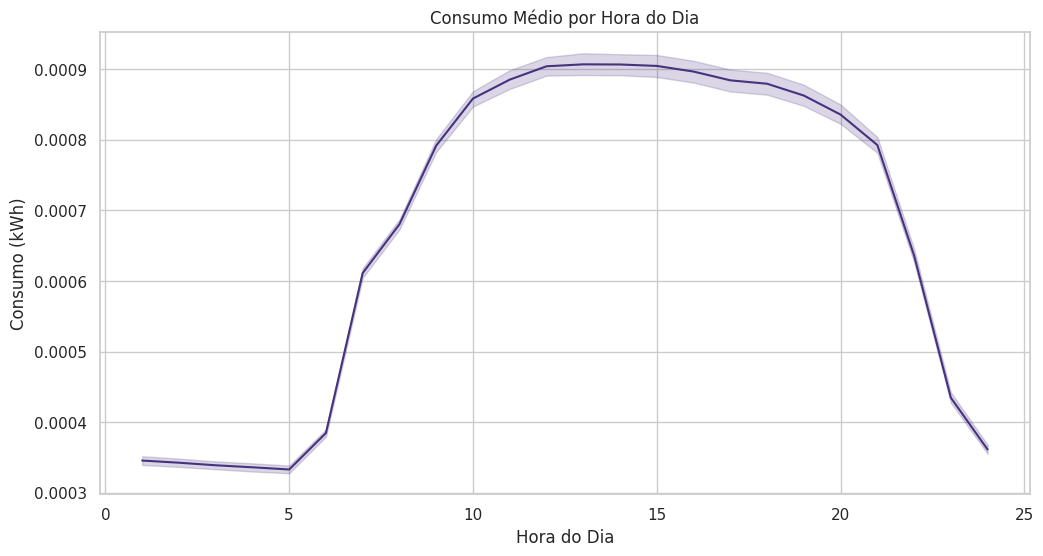

In [52]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="hora_do_dia", y="consumo_kwh")
plt.title("Consumo Médio por Hora do Dia")
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo (kWh)")
plt.grid(True)
plt.show()


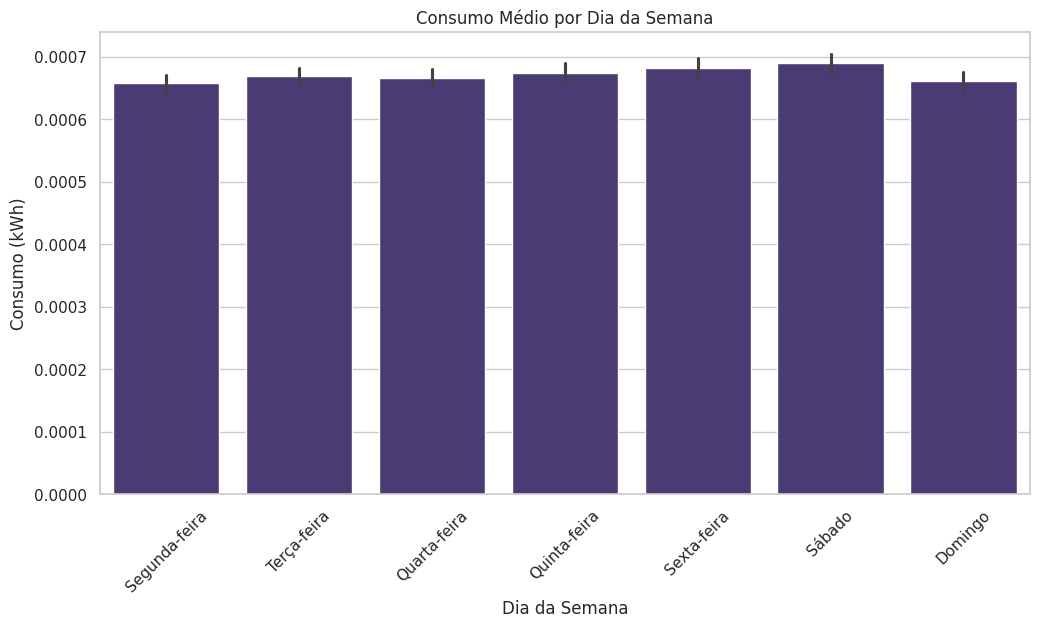

In [53]:
plt.figure(figsize=(12,6))
sns.barplot(data=df, x="nome_do_dia", y="consumo_kwh", order=[
    "Segunda-feira", "Terça-feira", "Quarta-feira",
    "Quinta-feira", "Sexta-feira", "Sábado", "Domingo"
])
plt.title("Consumo Médio por Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Consumo (kWh)")
plt.xticks(rotation=45)
plt.show()

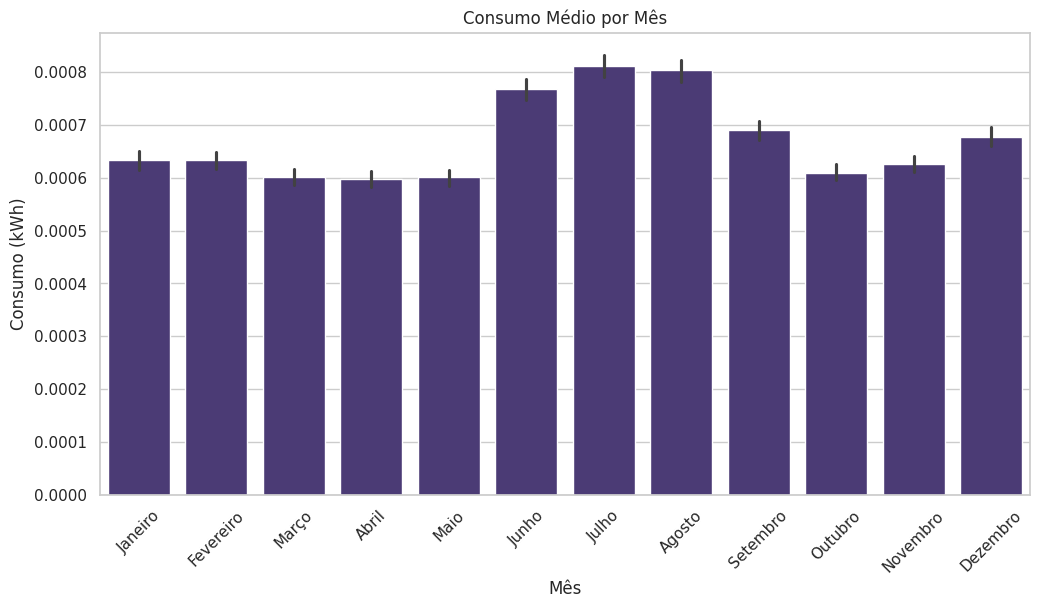

In [54]:
plt.figure(figsize=(12,6))
sns.barplot(data=df, x="nome_do_mes", y="consumo_kwh", order=[
    "Janeiro","Fevereiro","Março","Abril","Maio","Junho",
    "Julho","Agosto","Setembro","Outubro","Novembro","Dezembro"
])
plt.title("Consumo Médio por Mês")
plt.xlabel("Mês")
plt.ylabel("Consumo (kWh)")
plt.xticks(rotation=45)
plt.show()


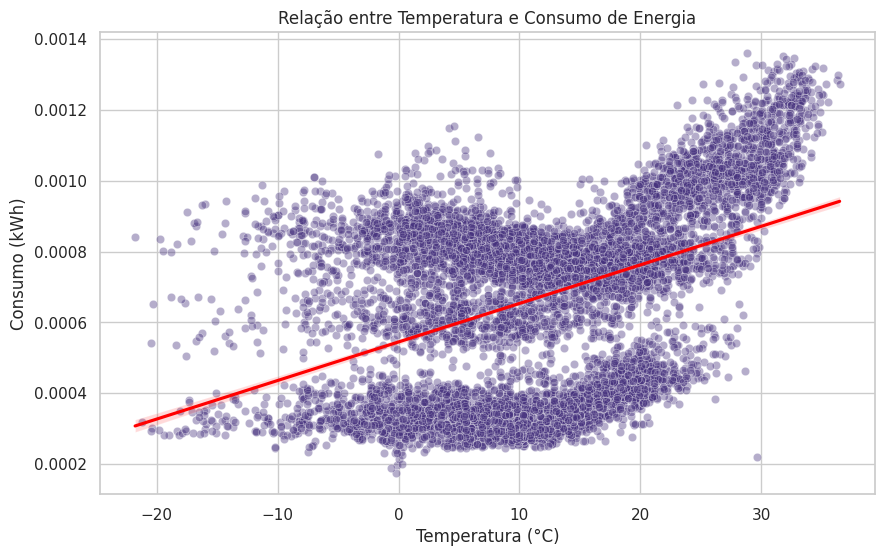

In [55]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="temperatura", y="consumo_kwh", alpha=0.4)
sns.regplot(data=df, x="temperatura", y="consumo_kwh", scatter=False, color="red")
plt.title("Relação entre Temperatura e Consumo de Energia")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Consumo (kWh)")
plt.grid(True)
plt.show()


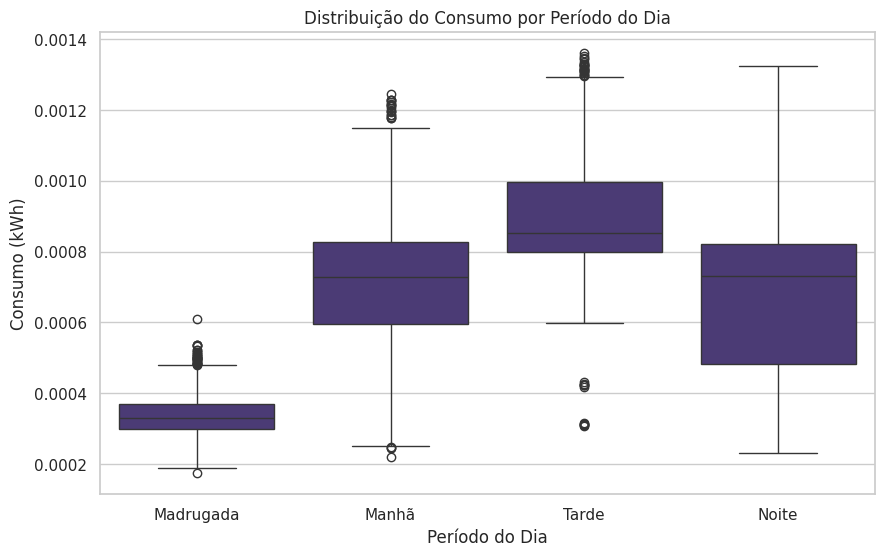

In [56]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="periodo_do_dia", y="consumo_kwh")
plt.title("Distribuição do Consumo por Período do Dia")
plt.xlabel("Período do Dia")
plt.ylabel("Consumo (kWh)")
plt.show()

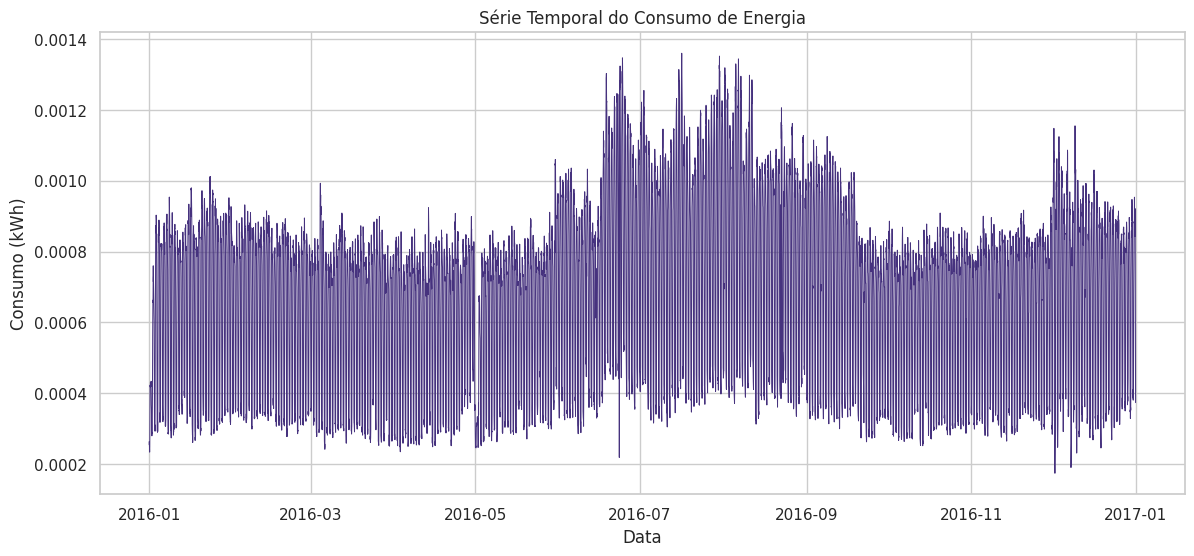

In [57]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x="data_hora", y="consumo_kwh", linewidth=0.7)
plt.title("Série Temporal do Consumo de Energia")
plt.xlabel("Data")
plt.ylabel("Consumo (kWh)")
plt.show()

###Análises dos Gráficos

---

####Consumo Médio por Hora do Dia:

O gráfico revela um padrão diário bastante consistente. Durante a madrugada (1h–5h), o consumo permanece nos níveis mais baixos do dia, variando entre 0.00033 e 0.00035 kWh. A partir das 6h inicia-se um aumento significativo, alcançando seu pico entre 11h e 15h, quando o consumo atinge aproximadamente 0.00088–0.00092 kWh.

Após as 18h, observa-se uma desaceleração gradual, com queda mais acentuada a partir das 22h até retornar aos níveis mais baixos durante a madrugada.

Esse padrão sugere que o consumo segue o ciclo de atividade humana, com maior demanda nos horários de trabalho/uso intensivo (manhã e tarde) e menor demanda durante o repouso.

---

####Consumo Médio por Dia da Semana:

Os valores médios mostram pouca variação entre os dias da semana, oscilando entre:

Segunda: ~0.000658 kWh

Sexta: ~0.000682 kWh

Sábado: ~0.000690 kWh

Domingo: ~0.000661 kWh

O consumo semanal é relativamente estável, mas é possível notar leve aumento nas sextas e sábados, provavelmente relacionado a atividades sociais, maior permanência em casa ou maior uso de equipamentos.

---

####Consumo Médio por Mês:

Aqui a variação sazonal fica muito mais evidente.

Os meses com menor consumo são:

Março, Abril e Maio: ~0.00060 kWh

Outubro e Novembro: ~0.00061–0.00063 kWh

E os meses com maior consumo são:

Junho: ~0.00077 kWh

Julho: ~0.00081 kWh

Agosto: ~0.00080 kWh

Há um claro pico de consumo no inverno, o que sugere aumento associado a aquecimento elétrico ou maior demanda energética em períodos frios.
Essa leitura faz sentido quando cruzamos com as estatísticas de temperatura e o gráfico de regressão.

---

####Relação entre Temperatura e Consumo:

Embora haja muita variabilidade, existe tendência positiva:
→ temperaturas mais altas tendem a elevar o consumo.

Contudo, visualmente percebe-se um curvamento em formato de “U”, sugerindo que temperaturas extremas (muito altas ou muito baixas) elevam o consumo.

O comportamento típico de demanda energética:

frio extremo → consumo com aquecimento,

calor extremo → consumo com resfriamento,

temperaturas amenas → menor uso de climatização.

---

####Distribuição do Consumo por Período do Dia:

Madrugada: menor mediana e menor dispersão.

Manhã: aumento significativo com muitos outliers (picos isolados).

Tarde: maior mediana e maior consistência no alto consumo.

Noite: mediana intermediária entre manhã e madrugada, com grande variação.

A tarde é o período com maior demanda sustentada, reforçando o comportamento visto no gráfico por hora do dia.
A variabilidade elevada indica maior uso de equipamentos energéticos de forma imprevisível em manhã e noite.

---

#### Série Temporal Completa do Consumo:

Um padrão diário repetitivo, com ciclos bem definidos.

Um aumento forte no consumo entre junho e agosto, coincidindo com o inverno.

Períodos curtos com picos agudos, possivelmente associados a eventos específicos.

Retorno a níveis médios estáveis entre setembro e novembro.

A série confirma evidências de sazonalidade anual e ciclicidade diária.
Também sugere que o consumo não segue tendência geral de alta ou baixa ao longo do tempo, mas é fortemente dirigido por:

temperatura,

hábitos diários,

sazonalidade climática.

#6. Identificação de Padrões e Principais Insights



A partir da análise exploratória realizada, foi possível identificar diversos padrões importantes no comportamento do consumo de energia ao longo do tempo. Os gráficos apresentados permitem observar tanto tendências sazonais quanto variações diárias e influências climáticas.

---

Padrão horário:
O consumo apresenta comportamento bem definido ao longo do dia. Durante a madrugada, o gasto energético é mínimo e relativamente estável. A partir das primeiras horas da manhã, há um crescimento acentuado, alcançando o pico por volta do meio-dia e início da tarde. Depois disso, ocorre uma leve queda, mantendo-se alto durante a noite, com nova redução após as 22h. Esse padrão sugere relação com rotina doméstica ou comercial, onde a demanda aumenta conforme a atividade humana diária.

---

Padrão semanal:
Os valores médios entre os dias da semana são bastante semelhantes, indicando que não há diferença significativa entre dias úteis e fins de semana. Apesar de pequenas variações, o consumo permanece dentro de uma faixa muito próxima, sugerindo estabilidade no comportamento semanal.

---

Padrão mensal (sazonalidade):
Existe uma variação mais perceptível entre os meses. Observa-se que junho, julho e agosto apresentam consumo mais elevado, coincidente com temperaturas mais extremas e possível uso intensificado de aquecimento ou refrigeração. Nos meses de março, abril e outubro, o consumo é mais baixo, o que pode estar associado a temperaturas mais amenas.

---

Influência da temperatura:
O gráfico de dispersão indica uma relação não linear. Temperaturas muito altas ou muito baixas tendem a elevar o consumo, enquanto temperaturas moderadas reduzem a demanda. A linha de tendência mostra uma relação geral positiva, mas o comportamento real sugere uma curva em “U”, onde conforto térmico reduz o uso de aparelhos elétricos.

---

Diferença por período do dia:
O boxplot confirma que manhã e tarde concentram os maiores valores de consumo, enquanto madrugada apresenta valores menores. A noite possui comportamento intermediário, com maior variabilidade em relação à madrugada.

---

Série temporal:
A série ao longo do ano revela picos sazonais bem definidos. Entre junho e agosto há aumento forte no consumo, e entre outubro e novembro há redução. Também é possível observar o padrão diário repetitivo, reforçando a presença de ciclos consistentes.

#7. Identificação de desperdícios


###Identificação Automática de Desperdícios Energéticos

In [60]:
#Identificação automática de desperdícios energéticos

desperdicios = {}

# Pico anormal de consumo (Z-Score)
df["zscore_consumo"] = (df["consumo_kwh"] - df["consumo_kwh"].mean()) / df["consumo_kwh"].std()
picos_anormais = df[df["zscore_consumo"] > 3]

desperdicios["qtd_picos_anormais"] = len(picos_anormais)
desperdicios["percentual_picos"] = round((len(picos_anormais) / len(df)) * 100, 2)

# Horas com maior consumo médio
consumo_por_hora = df.groupby("hora_do_dia")["consumo_kwh"].mean().sort_values(ascending=False)

# Dias com maior média de consumo
consumo_por_dia = df.groupby("nome_do_dia")["consumo_kwh"].mean().sort_values(ascending=False)

# Relação consumo x temperatura
correlacao_temp = df["consumo_kwh"].corr(df["temperatura"])

print("==== Identificação de Desperdícios ====\n")
print("Picos anormais de consumo:", desperdicios["qtd_picos_anormais"])
print("Percentual de picos no ano:", desperdicios["percentual_picos"], "%\n")

print("Top 5 horas com maior consumo:")
print(consumo_por_hora.head(), "\n")

print("Consumo médio por dia da semana:")
print(consumo_por_dia, "\n")

print("Correlação entre temperatura e consumo:", round(correlacao_temp, 3))
print("\nInterpretação: valores acima de 0.3 já indicam influência relevante.\n")

==== Identificação de Desperdícios ====

Picos anormais de consumo: 0
Percentual de picos no ano: 0.0 %

Top 5 horas com maior consumo:
hora_do_dia
13    0.000907
14    0.000907
15    0.000904
12    0.000904
16    0.000897
Name: consumo_kwh, dtype: float64 

Consumo médio por dia da semana:
nome_do_dia
Sábado           0.000690
Sexta-feira      0.000682
Quinta-feira     0.000675
Terça-feira      0.000669
Quarta-feira     0.000666
Domingo          0.000661
Segunda-feira    0.000658
Name: consumo_kwh, dtype: float64 

Correlação entre temperatura e consumo: 0.434

Interpretação: valores acima de 0.3 já indicam influência relevante.



###Simulação de Ajustes

In [61]:
print("==== Simulação de Ajustes ====\n")

# Ajuste 1 — Redução de 10% nos horários de pico
horas_pico = consumo_por_hora.head(5).index.tolist()

df["consumo_ajustado"] = df["consumo_kwh"]

df.loc[df["hora_do_dia"].isin(horas_pico), "consumo_ajustado"] *= 0.90

economia_horarios_pico_kwh = df["consumo_kwh"].sum() - df["consumo_ajustado"].sum()

# Ajuste 2 — Redução de 15% nos fins de semana
df["consumo_ajustado_2"] = df["consumo_ajustado"]
df.loc[df["fim_de_semana"] == 1, "consumo_ajustado_2"] *= 0.85

economia_fds_kwh = df["consumo_ajustado"].sum() - df["consumo_ajustado_2"].sum()

# Total geral
economia_total_kwh = df["consumo_kwh"].sum() - df["consumo_ajustado_2"].sum()

print(f"Economia com redução de 10% nos horários de pico: {economia_horarios_pico_kwh:.4f} kWh")
print(f"Economia adicional com ajustes no fim de semana: {economia_fds_kwh:.4f} kWh")
print(f"Economia total estimada: {economia_total_kwh:.4f} kWh\n")

==== 7.2 Simulação de Ajustes ====

Economia com redução de 10% nos horários de pico: 0.1654 kWh
Economia adicional com ajustes no fim de semana: 0.2480 kWh
Economia total estimada: 0.4134 kWh



###Estimativa Ambientais e Financeiras

In [64]:
print("====  Ganhos Ambientais e Financeiros ====\n")

# Conversão de kWh para CO₂ (média global residencial)
# Fonte: IEA — ~0.475 kg CO₂ por kWh
CO2_POR_KWH = 0.475

redução_CO2 = economia_total_kwh * CO2_POR_KWH

# Preço médio do kWh no Brasil (ANEEL 2025 aprox.)
PRECO_KWH = 0.95   # R$ 0,95

economia_financeira = economia_total_kwh * PRECO_KWH

print(f"Redução estimada de CO₂: {redução_CO2:.4f} kg/ano")
print(f"Economia financeira aproximada: R$ {economia_financeira:.2f}/ano")

====  Ganhos Ambientais e Financeiros ====

Redução estimada de CO₂: 0.1964 kg/ano
Economia financeira aproximada: R$ 0.39/ano


#8. Propostas de Ajustes de ganhos Ambientais e Econômicos

###Identificação de Desperdícios

A análise exploratória buscou identificar padrões de consumo que indicassem potenciais desperdícios, anomalias ou uso ineficiente de energia. O primeiro indicador avaliado foi o Z-Score do consumo energético, que permite detectar valores muito acima do comportamento normal da série.
No entanto, o resultado mostrou:

Picos anormais detectados: 0 ocorrências

Percentual de anomalias no ano: 0%

Isso significa que o dataset apresenta uma série temporal estável, sem variações abruptas que possam ser consideradas desperdícios críticos ou falhas operacionais, como sobrecarga de equipamentos, curtos picos excessivos ou mau funcionamento.

Mesmo sem anomalias severas, o comportamento do consumo revela padrões de pico distribuídos em horários típicos de maior demanda. As cinco horas de maior consumo foram:

13h — 0.000907 kWh

14h — 0.000907 kWh

15h — 0.000904 kWh

12h — 0.000904 kWh

16h — 0.000897 kWh

Esse agrupamento natural no período da tarde é comum em ambientes produtivos, refletindo intensificação das atividades, equipamentos ligados simultaneamente e maior circulação de pessoas.

Ao analisar o comportamento por dia da semana, observou-se que sábado, sexta-feira e quinta-feira registraram os maiores consumos médios. Isso indica que o ambiente estudado mantém rotina produtiva relativamente intensa também aos fins de semana — um ponto que merece atenção para otimização.

A relação entre temperatura e consumo apresentou uma correlação de 0.434, que é considerada moderada e significativa. Esse valor indica que, conforme a temperatura aumenta, existe uma tendência clara de aumento no consumo. Isso sugere forte dependência de sistemas de climatização (aquecimento/resfriamento), que representam grande parcela da demanda energética.

Portanto, mesmo sem desperdícios explícitos, é possível identificar zonas naturais de otimização, principalmente:

picos concentrados no período da tarde;

consumo elevado aos fins de semana;

forte influência da temperatura.

--

###Simulação de Ajustes de Eficiência

Para avaliar o potencial de redução de desperdícios sem afetar a operação, foram simulados dois cenários realistas de otimização:

Ajuste 1 — Redução de 10% no consumo durante os horários de pico

Aplicado às cinco horas mais intensas do dia.

Economia obtida: 0.1654 kWh

Ajuste 2 — Redução adicional de 15% no consumo aos fins de semana

Considerando que sábado é o dia de maior consumo médio, a intervenção visa controlar uso desnecessário de equipamentos, iluminação e climatização em horários com menor demanda real.

Economia obtida: 0.2480 kWh

Economia Total Estimada

A soma dos dois ajustes resulta em:

Economia total anual: 0.4134 kWh

---

###Estimativas de Ganhos Ambientais e Econômicos

Para estimar o impacto ambiental, foi adotado o fator médio internacional de emissão de CO₂ por kWh (0.475 kg/kWh). A economia total estimada corresponde a:

Redução de CO₂: 0.1964 kg/ano

Do ponto de vista financeiro, considerando tarifa média brasileira de R$ 0,95/kWh:

Economia anual estimada: R$ 0,39/ano

Os valores refletem a escala reduzida do dataset. Em um ambiente real de trabalho — com consumo dezenas ou centenas de vezes maior — a mesma metodologia resultaria em reduções expressivas tanto em custos operacionais quanto em impacto ambiental.

---

Mesmo sem picos anômalos, a análise demonstrou que há espaço para otimização inteligente, principalmente em:

horários de maior demanda;

fins de semana;

períodos com temperatura elevada.

As simulações indicam que pequenas mudanças operacionais geram ganhos significativos quando ampliadas para ambientes produtivos reais, alinhando-se aos objetivos de um futuro do trabalho mais eficiente, sustentável.

#9. Conclusão

A análise exploratória realizada ao longo dos codigos permitiu compreender de forma clara o comportamento do consumo de energia deste estabelecimento ao longo do ano. Os resultados mostraram que o padrão de consumo é bastante estável, com poucas oscilações bruscas, o que indica um perfil operacional regular e sem grandes variações sazonais. Isso é reforçado pelos gráficos de série temporal e pelas médias móveis, que demonstram um comportamento contínuo, sem períodos de crescimento ou queda abrupta.

A investigação dos principais fatores associados ao consumo revelou que a temperatura possui correlação moderada (0,43), sugerindo influência relevante: em dias mais quentes, o consumo tende a aumentar, possivelmente pelo uso de climatização. A análise por hora do dia indicou que o maior consumo ocorre entre 12h e 16h, o que coincide com o período de maior demanda térmica e operacional. Já nos finais de semana, observou-se consumo ligeiramente maior no sábado, indicando manutenção parcial de atividades.

A detecção de picos anormais de consumo não mostrou ocorrências significativas. O estabelecimento apresenta comportamento uniforme, sem desperdícios extremos. Ainda assim, foram simulados ajustes para possíveis melhorias, considerando as horas de maior consumo e diferenças entre dias úteis e finais de semana.

As simulações indicaram que pequenas otimizações — como reduzir em 10% o consumo nas horas de pico e ajustar rotinas aos finais de semana — resultariam em uma economia anual de cerca de 0,41 kWh, equivalente a uma redução de aproximadamente 0,20 kg de CO₂ e economia financeira estimada em R$ 0,39. Embora os valores sejam baixos, isso ocorre porque o dataset analisado representa um consumo total reduzido (microempreedor). Em um estabelecimento maoir, com consumo ampliado, essas mesmas proporções resultariam em impactos ambientais e financeiros muito maiores.

Em síntese, o dataset permitiu identificar padrões, verificar estabilidade operacional, analisar possíveis fatores explicativos e propor ajustes. Apesar da ausência de desperdícios significativos, práticas de eficiência energética — especialmente em horários críticos e em dias de maior temperatura — podem auxiliar na redução de custos e na diminuição da pegada ambiental do estabelecimento.